In [15]:
from PIL import Image

import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor, AutoTokenizer, BitsAndBytesConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = "HuggingFaceM4/idefics-9b-instruct"

# quantization_config = BitsAndBytesConfig(
#     load_in_8bit=True,
    # bnb_4bit_compute_dtype="float16",
# )
# model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=quantization_config, device_map="auto")

model = IdeficsForVisionText2Text.from_pretrained(checkpoint, torch_dtype=torch.bfloat16).to(device)
processor = AutoProcessor.from_pretrained(checkpoint)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

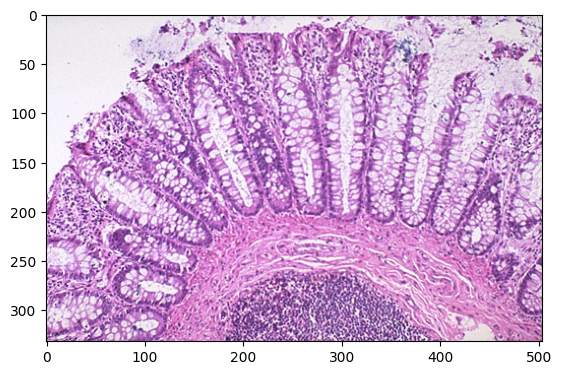

In [5]:
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load local image
image_paths = ["./imgs/colon_msi.png", 
               './imgs/GI208.jpg'
                # "./imgs/Tumour_infiltrating_lymphocytes_in_colorectal_carcinoma.jpg"
            ]

images = [Image.open(path) for path in image_paths]
_ = plt.imshow(images[-1])

In [7]:
prompts = [
    [
        "User:",
        images[0],
        "Describe this image.\nAssistant: An image of histopathological findings.\n",
        "User:",
        images[1],
        "Describe this image.\nAssistant:",
    ],
]

inputs = processor(prompts[0], return_tensors="pt").to(device)

generated_ids = model.generate(**inputs, max_length=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
# print(generated_text[0].split('\n')[23].split('User')[0][11:].strip('.'))
for i,t in enumerate(generated_text):
    print(f"{i}:\n{t}\n")

0:
User: Describe this image.
Assistant: An image of histopathological findings.
User: Describe this image.
Assistant: An image of histopathological findings.
User:



In [6]:
nejms = sorted(glob.glob('../../Datasets/NEJM/NEJM/*/*.png'))
answers = []  
for n in range(2, len(nejms)):
    image_paths = [nejms[n-2], nejms[n-1], nejms[n]]
    text_paths = [os.path.join(os.path.dirname(path), 'content.txt') for path in image_paths]
    images = [Image.open(path) for path in image_paths]
    texts = [open(path).read() for path in text_paths]
    
    lst = texts[0].split('\n')[1:8]
    lst.append('Assistant: ' + texts[0].split('\n')[8][8:] + '.\n')
    example = '\n'.join(lst)

    lst = texts[1].split('\n')[1:8]
    lst.append('Assistant: ' + texts[1].split('\n')[8][8:] + '.\n')
    example_ = '\n'.join(lst)

    lst = texts[2].split('\n')[1:8]
    lst.append('Assistant:')
    question = '\n'.join(lst)
    texts_ = [example, example_, question]
    break

In [16]:
from transformers import AutoTokenizer
n = 5
checkpoint = "HuggingFaceM4/idefics-80b-instruct"
tok = AutoTokenizer.from_pretrained(checkpoint)

image_paths = [nejms[n-2], nejms[n-1], nejms[n]]
text_paths = [os.path.join(os.path.dirname(path), 'content.txt') for path in image_paths]
images = [Image.open(path) for path in image_paths]
texts = [open(path).read() for path in text_paths]

lst = texts[0].split('\n')[1:8]
lst.append('Assistant: ' + texts[0].split('\n')[8][8:] + '. ' + texts[0].split('\n')[9])
example = '\n'.join(lst)

lst = texts[1].split('\n')[1:8]
lst.append('Assistant: ' + texts[1].split('\n')[8][8:] +  '. ' + texts[1].split('\n')[9])
example_ = '\n'.join(lst)

lst = texts[2].split('\n')[1:8]
lst.append('Assistant:')
question = '\n'.join(lst)
texts_ = [example, example_, question]

len(tok.encode(texts_[0]))+len(tok.encode(texts_[1]))+len(tok.encode(texts_[2]))
print(texts[-1])

ID: IC20051117
Question: What is the diagnosis?
Choices:
1. Budd chiari syndrome
2. Cutaneous larva migrans
3. Umbilical hernia
4. Portal hypertension
5. Gastric carcinoma
Answer: Portal hypertension
Reason: The image illustrates dilated veins radiating from the umbilicus secondary to portal hypertension.

